### 1. Sorting Images

In [2]:
import os, shutil
base_dir = 'C:/Users/user/PycharmProjects/ML_2022/Task_6/dogs-vs-cats'
original_data_dir = os.path.join(base_dir, 'train2')

train_dir = os.path.join(original_data_dir, 'train')
val_dir = os.path.join(original_data_dir, 'validation')
test_dir = os.path.join(original_data_dir, 'test')

os.mkdir(train_dir)
os.mkdir(val_dir)
os.mkdir(test_dir)

FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: 'C:/Users/user/PycharmProjects/ML_2022/Task_6/dogs-vs-cats\\train2\\train'

In [3]:
# Copy Image files for training set
fnames = ['cat.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
    src = os.path.join(original_data_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copy(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
    src = os.path.join(original_data_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copy(src, dst)

# Copy Image files for validation set
fnames = ['cat.{}.jpg'.format(i) for i in range(10000, 11250)]
for fname in fnames:
    src = os.path.join(original_data_dir, fname)
    dst = os.path.join(val_dir, fname)
    shutil.copy(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10000, 11250)]
for fname in fnames:
    src = os.path.join(original_data_dir, fname)
    dst = os.path.join(val_dir, fname)
    shutil.copy(src, dst)

# Copy Image files for test set
fnames = ['cat.{}.jpg'.format(i) for i in range(11250, 12500)]
for fname in fnames:
    src = os.path.join(original_data_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copy(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(11250, 12500)]
for fname in fnames:
    src = os.path.join(original_data_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copy(src, dst)

print("Finished")

Finished


In [4]:
print(f'the number of train set : {len(os.listdir(train_dir))}')
print(f'the number of valid set : {len(os.listdir(val_dir))}')
print(f'the number of test set : {len(os.listdir(test_dir))}')

the number of train set : 20000
the number of valid set : 2500
the number of test set : 2500


### 2. Loading Datasets

In [5]:
import torch
import PIL
import numpy as np
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 4

class CustomDataset(Dataset):    # Define new class CustomDataset for test datasets
    def __init__(self, files, root, train = False, transform=None):
        self.files = files
        self.root = root
        self.train = train
        self.transform = transform

        if 'cat' in files[0]:
            self.label = 0
        else:
            self.label = 1

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))

        if self.transform:
            img = self.transform(img)

        if self.train:
            return img, self.label
        else:
            return img, self.files[index]

print('Finished')

Finished


In [56]:
dog_file_names = [f'dog.{i}.jpg' for i in range(12500)]
cat_file_names = [f'cat.{i}.jpg' for i in range(12500)]

train_dog_dataset = CustomDataset(dog_file_names[:10000], train_dir, train=True, transform=preprocess)
train_cat_dataset = CustomDataset(cat_file_names[:10000], train_dir, train=True, transform=preprocess)
valid_dog_dataset = CustomDataset(dog_file_names[10000:11250], val_dir, train=True, transform=preprocess)
valid_cat_dataset = CustomDataset(cat_file_names[10000:11250], val_dir, train=True, transform=preprocess)
test_dog_dataset = CustomDataset(dog_file_names[11250:], test_dir, train=True, transform=preprocess)
test_cat_dataset = CustomDataset(cat_file_names[11250:], test_dir, train=True, transform=preprocess)

train_data = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_data = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_data = torch.utils.data.ConcatDataset([test_dog_dataset, test_cat_dataset])




In [76]:

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

print(type(trainloader))


<class 'torch.utils.data.dataloader.DataLoader'>


### 3. Define a Convolutional Neural Network

In [119]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(18432, 1600)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1600, 400)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(400, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

net1 = Net()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net1.to(device)


cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1600, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1600, out_features=400, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=400, out_features=2, bias=True)
)

### 4. Define a Loss function and optimizer

In [120]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)

### 5. Train the network

[epoch : 1, iteration   625] training loss: 0.6899
[epoch : 1, iteration    79] validation loss: 0.6908
[epoch : 2, iteration   625] training loss: 0.6427
[epoch : 2, iteration    79] validation loss: 0.6199
[epoch : 3, iteration   625] training loss: 0.6065
[epoch : 3, iteration    79] validation loss: 0.6111
[epoch : 4, iteration   625] training loss: 0.5720
[epoch : 4, iteration    79] validation loss: 0.5666
[epoch : 5, iteration   625] training loss: 0.5338
[epoch : 5, iteration    79] validation loss: 0.5275
[epoch : 6, iteration   625] training loss: 0.4871
[epoch : 6, iteration    79] validation loss: 0.5115
[epoch : 7, iteration   625] training loss: 0.4354
[epoch : 7, iteration    79] validation loss: 0.4716
[epoch : 8, iteration   625] training loss: 0.3633
[epoch : 8, iteration    79] validation loss: 0.5073
[epoch : 9, iteration   625] training loss: 0.2558
[epoch : 9, iteration    79] validation loss: 0.5763
[epoch : 10, iteration   625] training loss: 0.1374
[epoch : 10,

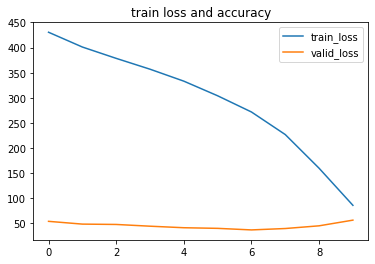

Finished Training


In [121]:
import matplotlib.pyplot as plt

epochs = 10

running_losses = []
valid_losses = []
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]

        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net1(inputs)    # Pass the inputs to the network, and get output
        loss = criterion(outputs, labels)    # Calculate cross entropy loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'[epoch : {epoch + 1}, iteration {i + 1:5d}] training loss: {running_loss / i:.4f}')

    # validation data check
    valid_loss = 0

    for i, data in enumerate(validloader):
        with torch.no_grad():
            net1.eval()
            images, labels = data[0].to(device), data[1].to(device)
            prediction = net1(images)
            loss = criterion(prediction, labels)    # Calculate cross entropy loss
        valid_loss += loss.item()

    print(f'[epoch : {epoch + 1}, iteration {i + 1:5d}] validation loss: {valid_loss / i:.4f}')

    running_losses.append(running_loss)
    valid_losses.append(valid_loss)

plt.plot(running_losses, label='train_loss')
plt.plot(valid_losses, label='valid_loss')
plt.legend()
plt.title('train loss and accuracy')
plt.show()



print('Finished Training')

In [89]:
PATH = './cats_vs_dogs.pth'
torch.save(net1.state_dict(), PATH)

### 6. Test the network

In [104]:
net = Net()
net.to(device)
net.load_state_dict(torch.load(PATH))

<class 'int'>


In [115]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    result = {'TP':0, 'TN':0, 'FP':0, 'FN':0}
    predicted = []
    test_loss = 0
    for i, data in enumerate(testloader):
        net.eval()
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)

        _, predicted_temp = torch.max(outputs, 1)
        predicted += [int(i) for i in predicted_temp]

        for m, n in zip(labels, predicted_temp):    # Take cat as positive
            if m == 0 and n == 0:
                result['TP'] += 1
            elif m == 1 and n == 1:
                result['TN'] += 1
            elif m == 1 and n == 0:
                result['FN'] += 1
            else:
                result['FP'] += 1

        test_loss += loss.item()/len(testloader)

    print(result)

{'TP': 995, 'TN': 972, 'FP': 255, 'FN': 278}


In [118]:

test_accuracy = 100 * (result['TP'] + result['TN'])/(result['TP'] + result['TN'] + result['FN'] + result['FP'])
test_precision = result['TP']/(result['TP'] + result['FP'])
test_recall = result['TP']/(result['TP'] + result['FN'])
test_f1_score = 2 * test_recall * test_precision / (test_recall + test_precision)

print(f'test loss : {test_loss:.3f}')
print(f'test accuracy : {test_accuracy} %')
print(f'test precision : {test_precision:.3f}')
print(f'test recall : {test_recall:.3f}')
print(f'F1 score : {test_f1_score:.3f}')


test loss : 0.522
test accuracy : 78.68 %
test precision : 0.796
test recall : 0.782
F1 score : 0.789


### 7. Write .CSV file for submission

In [ ]:

indices = [i for i in range(1, 12501)]
lines = ['id,label\n'] + [str(m) + ',' + str(n) +'\n' for m,n in zip(indices, predicted)]
print(lines)
with open('submission.csv', 'w') as f:
    f.writelines(lines)